# **DeepFusion: Multi-Modal Product Intelligence**

This project builds a deep learning system that can classify and understand e-commerce products by combining two sources of information: product images and structured data like category and other metadata. The goal is to improve the accuracy of product categorization, which in turn helps with better search, smarter recommendations, fraud checks, and an overall smoother shopping experience across an e-commerce catalog.

In practice, the model is meant to automate product tagging and validation. Today, many teams still rely heavily on manual labeling, which is slow and inconsistent, or on pipelines that use only metadata or only images. Both approaches miss important context. By fusing images with metadata, this system can capture a fuller picture of the product and cut down on costly misclassification errors that affect conversions.

The problem is framed as a multi-class classification task, trained offline with labeled data. The model predicts the correct product category, and its performance is judged by accuracy and F1-score. These metrics make sure the system isn’t just precise on common items but also holds up well on less frequent categories, which is key for reliable, large-scale use.

The challenge is similar to recommendation engines, search ranking, or fraud detection, where multiple types of information need to be blended. Right now, product managers and merchandisers handle this classification by hand, but the process doesn’t scale and is prone to errors. Automating it with a model offers both speed and consistency.

This work assumes that product images and metadata are reasonably clean and consistent. Even under that basic assumption, a solid baseline model would already beat manual classification in speed and accuracy, while more advanced versions could keep improving over time.

## **DATA COLLECTION**


In order to train and evaluate the DeepFusion: Multi-Modal Product Intelligence model, we require a dataset that provides both visual data (product images) and structured metadata. For this project, we use the E-ComRec Dataset from Kaggle. This dataset is highly suitable because it contains product details and image URLs, allowing us to build a multi-input deep learning pipeline that fuses visual and tabular data. The combination of multiple modalities closely mirrors real-world e-commerce applications, where decisions are rarely based on images alone but also rely on structured attributes.

In [1]:
# Install kagglehub
!pip install -q kagglehub

import kagglehub

# Download the E-ComRec Dataset
path = kagglehub.dataset_download("ziya07/e-comrec-dataset")

print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'e-comrec-dataset' dataset.
Dataset downloaded to: /kaggle/input/e-comrec-dataset


## **DATA EXTRACTION & PREPARATION**

**In this section, we will:**

1. Load the main metadata file `styles.csv` from the Myntra dataset.
2. Inspect the available columns and check class distribution (articleType).
3. Match each product row with its corresponding image file.
4. Filter out rows where the image file is missing.
5. Remove very rare categories (articleTypes with <100 samples) to keep training stable.

This ensures that our dataset is clean, balanced enough for classification,
and ready for building tf.data pipelines later.

In [2]:
# Import libraries
import os
import glob
import pandas as pd
import numpy as np

In [3]:
# Locate path to our dataset
DATA_ROOT = path
MYNTRA_ROOT = os.path.join(DATA_ROOT, "archive (8)", "myntradataset")
STYLES_CSV = os.path.join(MYNTRA_ROOT, "styles.csv")
IMG_DIR = os.path.join(MYNTRA_ROOT, "images")

print("styles.csv path:", STYLES_CSV)
assert os.path.exists(STYLES_CSV), "styles.csv not found - check MYNTRA_ROOT"

styles.csv path: /kaggle/input/e-comrec-dataset/archive (8)/myntradataset/styles.csv


In [4]:
# Load styles.csv
styles = pd.read_csv(STYLES_CSV, on_bad_lines="skip")
print("styles.csv loaded. Shape:",styles.shape)
print("Columns:", styles.columns.tolist())

styles.csv loaded. Shape: (44424, 10)
Columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


In [5]:
# Display first few rows
display(styles.head())

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
# Check class distribution for target column (articleType)
print("Number of classes (articleType):", styles["articleType"].nunique())

Number of classes (articleType): 143


In [7]:
# Top articleTypes
article_counts = styles["articleType"].value_counts()
print("\nTop 20 most common articletypes:")
print(article_counts.head(20))


Top 20 most common articletypes:
articleType
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Name: count, dtype: int64


In [8]:
# Build full image paths
styles["image_path"] = styles["id"].apply(lambda x: os.path.join(IMG_DIR, f"{x}.jpg"))
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/e-comrec-dataset/archive (8)/myn...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/e-comrec-dataset/archive (8)/myn...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/e-comrec-dataset/archive (8)/myn...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...


In [9]:
# Keep only rows where image file actually exists
styles = styles[styles["image_path"].apply(os.path.exists)].reset_index(drop=True)
print("Remaining rows after filtering images:", len(styles))

Remaining rows after filtering images: 44419


In [10]:
# Filter out rare categories with less than 100 samples
min_samples = 100
valid_articles = styles["articleType"].value_counts()[lambda x: x>= min_samples].index
styles = styles[styles["articleType"].isin(valid_articles)].reset_index(drop=True)

print("Classes after filtering:", styles["articleType"].nunique())
print("Dataset size after filtering:", len(styles))

Classes after filtering: 54
Dataset size after filtering: 42150


In [11]:
# Check table
display(styles.head())

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/e-comrec-dataset/archive (8)/myn...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/e-comrec-dataset/archive (8)/myn...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/e-comrec-dataset/archive (8)/myn...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...


## **TRAIN / VALIDATION / TEST SPLIT**

Now that we have a dataset of 42,150 products (each with metadata and a valid image), the next step is to split it into training, validation, and test sets. This is important for fair evaluation and to avoid data leakage.

We first set aside 10% of the data as the test set. This portion will only be touched at the very end to give us an unbiased view of how the model performs on completely unseen products. From the remaining data, we carve out another 10% for validation. This validation set is used during training to guide choices like hyperparameters and early stopping. The rest — about 81% — is the training set, which the model uses to actually learn patterns from the product images and metadata.

To keep things balanced, we use stratified sampling on the articleType column. This ensures the category distribution is preserved across training, validation, and test splits, so no subset ends up missing rare classes. We also fix the random seed (random_state=42) to make the splits reproducible, which is useful for debugging and comparing results later.

In [12]:
from sklearn.model_selection import train_test_split

# Train/Test split (10% test)
train_df, test_df = train_test_split(
    styles, test_size=0.1, stratify=styles["articleType"], random_state=42
)

In [13]:
# Train/Validation split (10% of remaining for validation)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, stratify=train_df["articleType"], random_state=42
)

In [14]:
# View size of the split
print(f"Total dataset size: {len(styles)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Total dataset size: 42150
Train size: 34141
Validation size: 3794
Test size: 4215


In [15]:
# Quick look at 3 samples
display(train_df.head(3)[["id", "articleType", "image_path"]])

,id,articleType,image_path
41130,2493,Tshirts,/kaggle/input/e-comrec-dataset/archive (8)/myn...
32058,37312,Watches,/kaggle/input/e-comrec-dataset/archive (8)/myn...
25945,3969,Tops,/kaggle/input/e-comrec-dataset/archive (8)/myn...


## **EXPLORATORY DATA ANALYSIS**

In this section, we’ll take a closer look at the training dataset (train_df) before moving into model building. The goal of this exploratory data analysis (EDA) is to understand the data, spot imbalances, and catch potential issues early, such as missing values or inconsistent labels.

**The steps we’ll go through:**

- Dataset overview — check shape, column types, missing values, and duplicates.

- Data quality check — review numerical summaries, unique values, and string formatting issues.

- Target distribution — examine how articleType is spread across categories and highlight the most common ones.

- Metadata distributions — explore fields like gender, masterCategory, subCategory, baseColour, season, and year.

- Relationships — look at how articleType interacts with other features (e.g., articleType vs gender).

- Image validation — confirm that all image paths are valid and images exist.

- Sample inspection — display a few product images alongside their metadata.

This EDA gives us a clear picture of the dataset and helps shape the preprocessing steps that come next.


In [16]:
# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Work with copy of the data
eda_df = train_df.copy()

In [17]:
# Dataset overview
print("Data set shape:", eda_df.shape)
print("\nColumns:", eda_df.columns.tolist())
print("\nData types:\n", eda_df.dtypes)
print("\nMissing values per column:\n", eda_df.isnull().sum())

Data set shape: (34141, 11)

Columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image_path']

Data types:
 id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
image_path             object
dtype: object

Missing values per column:
 id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             11
season                 16
year                    1
usage                 152
productDisplayName      3
image_path              0
dtype: int64


Our dataset has 34,141 rows and 11 columns.
A few columns have missing values (`baseColour`, `season`, `year`, `usage`, `productDisplayName`) — we'll clean these later.


In [18]:
# Data quality checks
dup_count = eda_df.duplicated().sum()
print(f"\nNumber of duplicated rows: {dup_count}")


Number of duplicated rows: 0


In [19]:
# Numeric summary
print("\nSummary statistics for numeric columns:")
print(eda_df.describe())


Summary statistics for numeric columns:
                 id          year
count  34141.000000  34140.000000
mean   29143.620925   2012.747217
std    16951.518232      2.091807
min     1163.000000   2007.000000
25%    14171.000000   2011.000000
50%    28071.000000   2012.000000
75%    43916.000000   2015.000000
max    60000.000000   2019.000000


In [20]:
# Check string neatness which include leading/trailing spaces and case issues
str_cols = eda_df.select_dtypes(include="object").columns

for col in str_cols:
    sample_vals = eda_df[col].dropna().unique()[:5]
    print(f"\nColumn '{col}' sample values: {sample_vals}")

    # Check for leading/trailing spaces
    if eda_df[col].dropna().str.contains(r"^\s+|\s+$", regex=True).any():
        print(f"Column '{col}' has leading/trailing spaces")

    # Check for inconsistent casing
    unique_vals = eda_df[col].dropna().unique()
    lower_vals = [str(v).lower() for v in unique_vals]
    if len(set(lower_vals)) < len(set(unique_vals)):
        print(f"Column '{col}' may have inconsistent casing")


Column 'gender' sample values: ['Men' 'Women' 'Unisex' 'Girls' 'Boys']

Column 'masterCategory' sample values: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items']

Column 'subCategory' sample values: ['Topwear' 'Watches' 'Shoes' 'Bags' 'Flip Flops']

Column 'articleType' sample values: ['Tshirts' 'Watches' 'Tops' 'Casual Shoes' 'Backpacks']

Column 'baseColour' sample values: ['White' 'Silver' 'Black' 'Grey' 'Red']

Column 'season' sample values: ['Fall' 'Winter' 'Summer' 'Spring']

Column 'usage' sample values: ['Casual' 'Sports' 'Ethnic' 'Formal' 'Smart Casual']

Column 'productDisplayName' sample values: ["Puma Men's White Polo T-shirt"
 'Casio Edifice Men Multi-Dial Watch EF-334D-7AVDF(ED422)'
 'Jealous 21 Women Black V Neck With Sequins Top'
 'Numero Uno Men Black Shoes'
 'United Colors of Benetton Men Black Backpack']
Column 'productDisplayName' has leading/trailing spaces
Column 'productDisplayName' may have inconsistent casing

Column 'image_path' sample values: 

We checked string columns for extra spaces and inconsistent casing.  
Some issues were found (e.g., in `productDisplayName`) — we'll clean these next.

In [21]:
# Target variable distribution
article_counts = eda_df["articleType"].value_counts()
print("\nNumber of unique artcleTypes", article_counts.nunique())


Number of unique artcleTypes 53


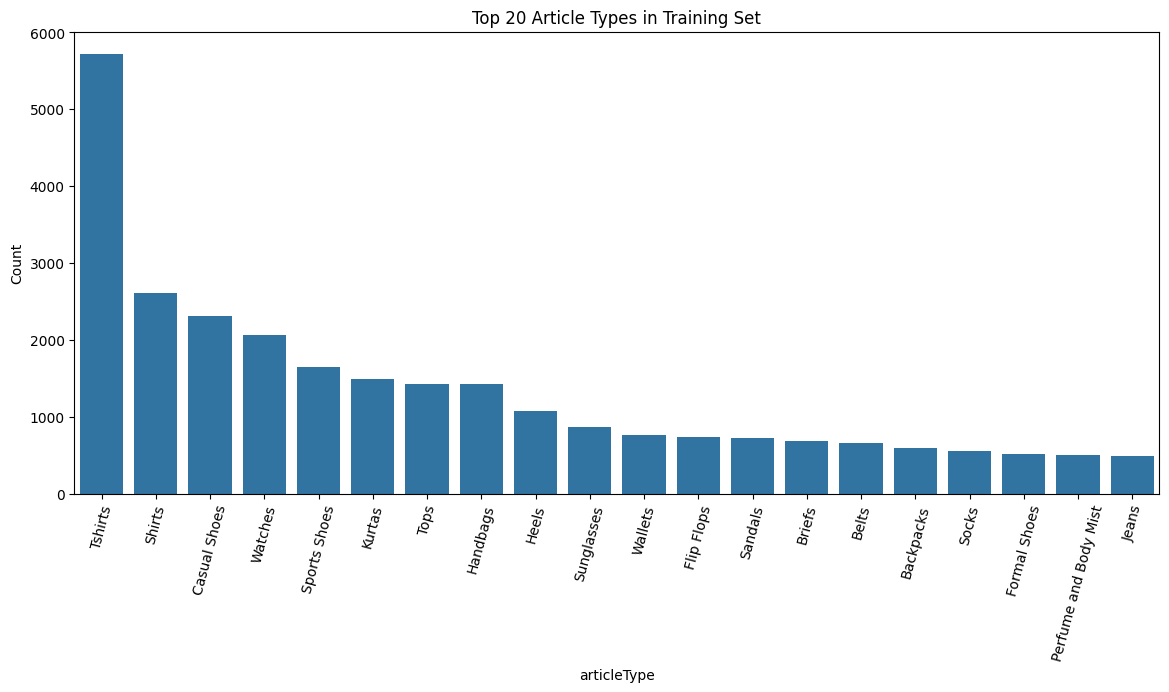

In [22]:
# Target visualization
plt.figure(figsize=(14,6))
sns.barplot(x=article_counts.head(20).index, y=article_counts.head(20).values)
plt.xticks(rotation=75)
plt.title("Top 20 Article Types in Training Set")
plt.ylabel("Count")

# Save figure
plt.savefig("top20_article_types.png", bbox_inches="tight")

plt.show()

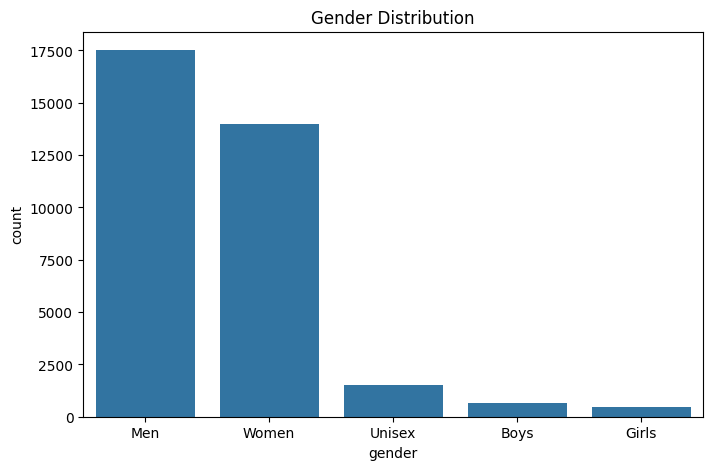

In [23]:
# Gender distribution
plt.figure(figsize=(8,5))
sns.countplot(data=eda_df, x="gender", order=eda_df["gender"].value_counts().index)
plt.title("Gender Distribution")

# Save figure
plt.savefig("gender_distribution.png", bbox_inches="tight")

plt.show()

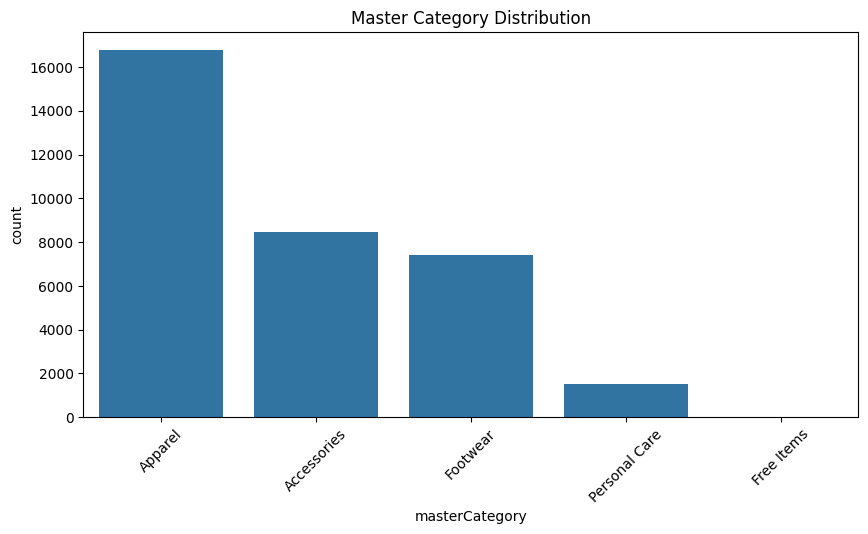

In [24]:
# Master category distribution
plt.figure(figsize=(10,5))
sns.countplot(data=eda_df, x="masterCategory", order=eda_df["masterCategory"].value_counts().index)
plt.title("Master Category Distribution")
plt.xticks(rotation=45)

# Save figure
plt.savefig("mastercategory_distribution.png", bbox_inches="tight")

plt.show()

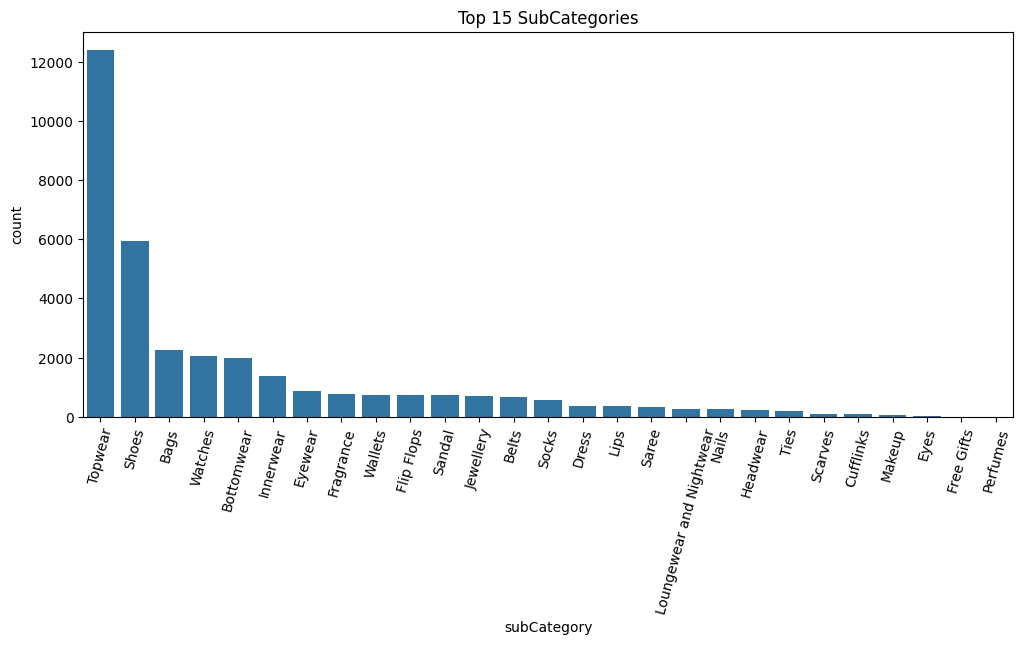

In [25]:
# Top 15 Sub Category
plt.figure(figsize=(12,5))
sns.countplot(data=eda_df, x="subCategory", order=eda_df["subCategory"].value_counts().index)
plt.title("Top 15 SubCategories")
plt.xticks(rotation=75)

# Save figure
plt.savefig("top15_subcategories.png", bbox_inches="tight")

plt.show()

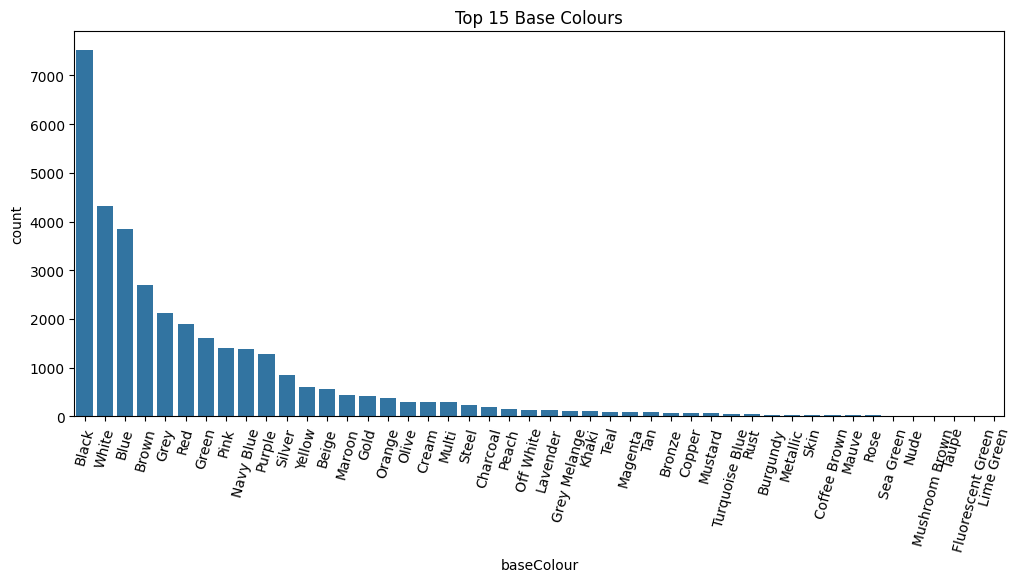

In [26]:
# Top 15 Base Colours
plt.figure(figsize=(12,5))
sns.countplot(data=eda_df, x="baseColour", order=eda_df["baseColour"].value_counts().index)
plt.title("Top 15 Base Colours")
plt.xticks(rotation=75)

# Save figure
plt.savefig("top15_base_colours.png", bbox_inches="tight")

plt.show()

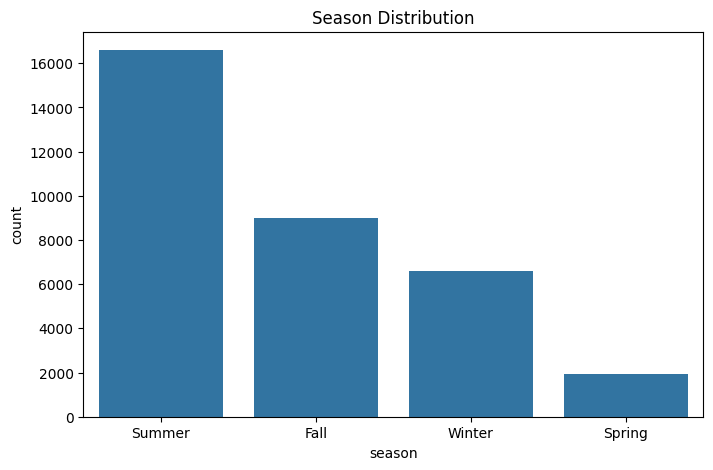

In [27]:
# Season distribution
plt.figure(figsize=(8,5))
sns.countplot(data=eda_df, x="season", order=eda_df["season"].value_counts().index)
plt.title("Season Distribution")

# Save figure
plt.savefig("season_distribution.png", bbox_inches="tight")

plt.show()

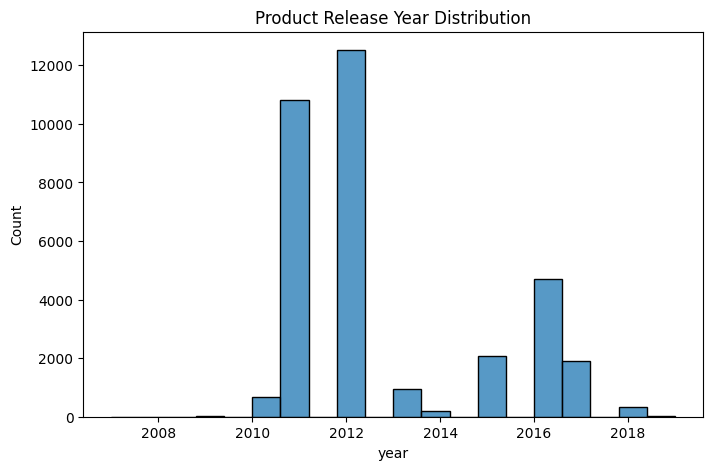

In [28]:
# Year distribution
plt.figure(figsize=(8,5))
sns.histplot(eda_df["year"].dropna(), bins=20, kde=False)
plt.title("Product Release Year Distribution")

# Save figure
plt.savefig("product_release_year_distribution.png", bbox_inches="tight")

plt.show()

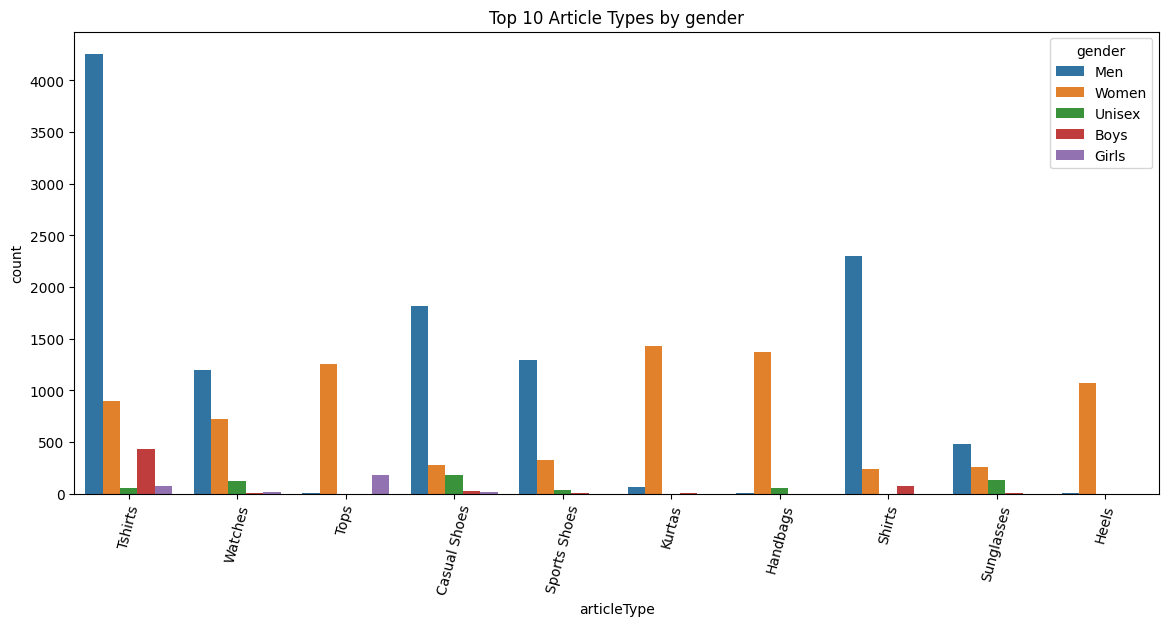

In [29]:
# ArticleType vs Gender
top10_types = article_counts.head(10).index

plt.figure(figsize=(14,6))
sns.countplot(data=eda_df[eda_df["articleType"].isin(top10_types)],
              x="articleType", hue="gender")
plt.title("Top 10 Article Types by gender")
plt.xticks(rotation=75)

# Save figure
plt.savefig("top10_article_types_by_gender.png", bbox_inches="tight")

plt.show()

In [30]:
# Missing images files
missing_images = eda_df[~eda_df["image_path"].apply(os.path.exists)]
print("Missing image files in training set:", len(missing_images))

Missing image files in training set: 0


In [31]:
# Outlier Detection for numeric column(year) using IQR Method
Q1 = eda_df["year"].quantile(0.25)
Q3 = eda_df["year"].quantile(0.75)
IQR = Q3 - Q1

lower_bound =  Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = eda_df[(eda_df["year"] < lower_bound) | (eda_df["year"] > upper_bound)]

print(f"Year column: {len(outliers)} outliers found")
print("Year range:", eda_df["year"].min(), "-", eda_df["year"].max())
print("Outlier years:\n", outliers["year"].value_counts().sort_index())

Year column: 0 outliers found
Year range: 2007.0 - 2019.0
Outlier years:
 Series([], Name: count, dtype: int64)


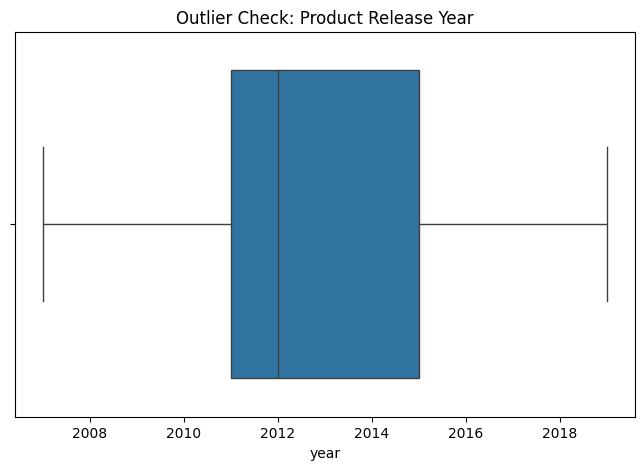

In [32]:
# Visualize outlier check with boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x=eda_df["year"])
plt.title("Outlier Check: Product Release Year")

# Save figure
plt.savefig("outlier_check.png", bbox_inches="tight")

plt.show()

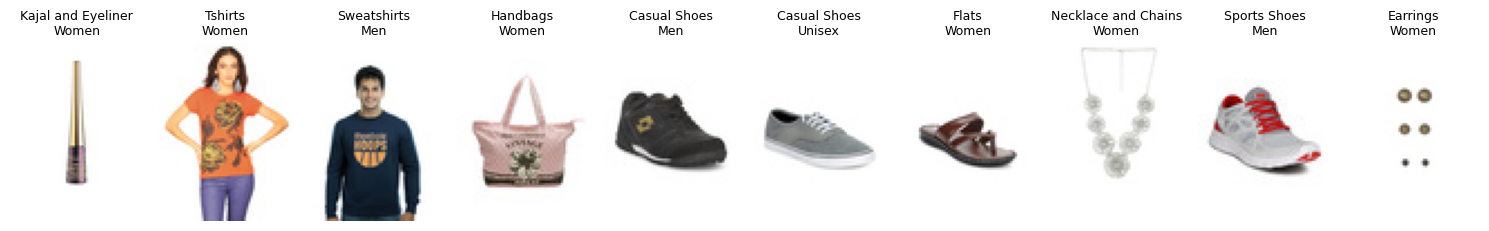

In [33]:
# Visualize few image sample
import random
from PIL import Image

sample_rows = eda_df.sample(10, random_state=42)

plt.figure(figsize=(15,8))
for i, (_, row) in enumerate(sample_rows.iterrows()):
    plt.subplot(1,10,i+1)
    try:
        img = Image.open(row["image_path"])
        plt.imshow(img)
    except:
        plt.text(0.5, 0.5, "Image Not Found", ha="center")
    plt.axis("off")
    plt.title(f"{row["articleType"]}\n{row["gender"]}", fontsize=9)
plt.tight_layout()

# Save figure
plt.savefig("image_sample.png", bbox_inches="tight")

plt.show()

## **DATA PREPROCESSING AND FEATURE ENGINEERING**

Before using the data in a recommendation model, we need to make sure it is clean, consistent, and ready for deep learning. Raw datasets often include missing values, duplicates, inconsistent labels, or mixed formats — all of which can hurt model accuracy.

In this section, we will:

- Handle missing values and fix data quality issues.

- Standardize and clean categorical and text fields.

- Create extra features if useful (e.g., text normalization).

- Encode categorical variables into numeric form.

- Scale numerical features so each input has equal weight.

- Build a ColumnTransformer pipeline to automate preprocessing across training, validation, and test splits.

This process will leave us with a dataset that is reliable, consistent, and reproducible for model training.

In [34]:
# Work on copy of train data
df = train_df.copy()

In [35]:
# View first few rows
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
41130,2493,Men,Apparel,Topwear,Tshirts,White,Fall,2010.0,Casual,Puma Men's White Polo T-shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
32058,37312,Men,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Casio Edifice Men Multi-Dial Watch EF-334D-7AV...,/kaggle/input/e-comrec-dataset/archive (8)/myn...
25945,3969,Women,Apparel,Topwear,Tops,Black,Summer,2011.0,Casual,Jealous 21 Women Black V Neck With Sequins Top,/kaggle/input/e-comrec-dataset/archive (8)/myn...
39058,55623,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Numero Uno Men Black Shoes,/kaggle/input/e-comrec-dataset/archive (8)/myn...
22634,37227,Men,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,United Colors of Benetton Men Black Backpack,/kaggle/input/e-comrec-dataset/archive (8)/myn...


In [36]:
# Handle missing values by filling numeric values with median
df["year"] = df["year"].fillna(df["year"].median())

In [37]:
# Fill categorical values with "Unknown"
for col in ["baseColour", "season", "usage"]:
    df[col] = df[col].fillna("Unknown")

In [38]:
# Fill NA in productDisplayName column with empty space
df["productDisplayName"] = df["productDisplayName"].fillna("")

In [39]:
# Check for any existing missing values
df.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,0
season,0
year,0
usage,0
productDisplayName,0


In [40]:
# Strip spaces and standardize case for product names
df["productDisplayName"] = df["productDisplayName"].str.strip().str.lower()

In [41]:
# Remove special characters from productDisplayName column
import re

df['productDisplayName'] = df['productDisplayName'].apply(
    lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x)
)

In [42]:
# Display table
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
41130,2493,Men,Apparel,Topwear,Tshirts,White,Fall,2010.0,Casual,puma mens white polo tshirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
32058,37312,Men,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,casio edifice men multidial watch ef334d7avdfe...,/kaggle/input/e-comrec-dataset/archive (8)/myn...
25945,3969,Women,Apparel,Topwear,Tops,Black,Summer,2011.0,Casual,jealous 21 women black v neck with sequins top,/kaggle/input/e-comrec-dataset/archive (8)/myn...
39058,55623,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,numero uno men black shoes,/kaggle/input/e-comrec-dataset/archive (8)/myn...
22634,37227,Men,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,united colors of benetton men black backpack,/kaggle/input/e-comrec-dataset/archive (8)/myn...


In [43]:
# Display data types
print(df.dtypes)

id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
image_path             object
dtype: object


In [44]:
# Convert 'year' to integer
df["year"] = df["year"].astype(int)

In [45]:
# Derive product length features
df["name_length"] = df["productDisplayName"].apply(lambda x: len(x.split()))

In [46]:
# Display table
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path,name_length
41130,2493,Men,Apparel,Topwear,Tshirts,White,Fall,2010,Casual,puma mens white polo tshirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...,5
32058,37312,Men,Accessories,Watches,Watches,Silver,Winter,2016,Casual,casio edifice men multidial watch ef334d7avdfe...,/kaggle/input/e-comrec-dataset/archive (8)/myn...,6
25945,3969,Women,Apparel,Topwear,Tops,Black,Summer,2011,Casual,jealous 21 women black v neck with sequins top,/kaggle/input/e-comrec-dataset/archive (8)/myn...,9
39058,55623,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012,Casual,numero uno men black shoes,/kaggle/input/e-comrec-dataset/archive (8)/myn...,5
22634,37227,Men,Accessories,Bags,Backpacks,Black,Summer,2012,Casual,united colors of benetton men black backpack,/kaggle/input/e-comrec-dataset/archive (8)/myn...,7


In [47]:
# Display data types of the data
print(df.dtypes)

id                     int64
gender                object
masterCategory        object
subCategory           object
articleType           object
baseColour            object
season                object
year                   int64
usage                 object
productDisplayName    object
image_path            object
name_length            int64
dtype: object


In [48]:
# Define features group
numeric_features = ["year", "name_length"]
categorical_features = ["gender", "masterCategory", "subCategory",
                        "baseColour", "season", "usage"]

In [49]:
# Build numeric preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [50]:
# Build categorical preprocessing pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [51]:
# Combine all transformations
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [52]:
# Wrap preprocessing + model into one pipeline later, but for now we have only preprocessor
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])

In [53]:
# Display columns
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'image_path', 'name_length'],
      dtype='object')

In [54]:
# Define our X and y
col = ["id", "image_path", "productDisplayName", "articleType"]
X = df.drop(columns=col, axis=1)
y = df["articleType"]

In [55]:
# Display our features table
(print(X.head()))

      gender masterCategory subCategory baseColour  season  year   usage  \
41130    Men        Apparel     Topwear      White    Fall  2010  Casual   
32058    Men    Accessories     Watches     Silver  Winter  2016  Casual   
25945  Women        Apparel     Topwear      Black  Summer  2011  Casual   
39058    Men       Footwear       Shoes      Black  Summer  2012  Casual   
22634    Men    Accessories        Bags      Black  Summer  2012  Casual   

       name_length  
41130            5  
32058            6  
25945            9  
39058            5  
22634            7  


In [56]:
# Fit and transform
X_processed = pipeline.fit_transform(X)
print("Shape after preprocessing", X_processed.shape)

Shape after preprocessing (34141, 99)


In [57]:
# Fit and transform y
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_processed = label_encoder.fit_transform(y)

We’ll now create a function that incorporate all these data transformation processes so that same can be applied to test and validation data.
  
It will clean text, fill missing values, add a `name_length` feature,  
scale numeric columns, encode categorical fields, and encode the target (`articleType`).  
This will work for training, validation, and test data.  


In [58]:
# Define the function

def preprocess_data(df, fit=False, preprocessor=None, label_encoder=None):
    """
    Full preprocessing pipeline for train/val/test data.

    Steps:
    - Handle missing values
    - Clean and standardize productDisplayName
    - Derive name_length feature
    - Scale numeric features
    - One-hot encode categorical features
    - Encode target y (articleType)

    Arguments:
        df (pd.DataFrame): input dataset
        fit (bool): whether to fit transformers (True for train, False for val/test)
        preprocessor (ColumnTransformer): fitted preprocessor (required if fit=False)
        label_encoder (LabelEncoder): fitted label encoder for y (required if fit=False)

    Returns:
        X_processed (np.ndarray): transformed features
        y_encoded (np.ndarray): encoded target
        preprocessor (ColumnTransformer): fitted preprocessor (returned if fit=True)
        label_encoder (LabelEncoder): fitted label encoder (returned if fit=True)
    """

    df = df.copy()

    # Handle missing values
    df["year"] = df["year"].fillna(df["year"].median())
    for col in ["baseColour", "season", "usage"]:
        df[col] = df[col].fillna("Unknown")
    df["productDisplayName"] = df["productDisplayName"].fillna("")


    # Clean productDisplayName
    df["productDisplayName"] = (
        df["productDisplayName"]
        .str.strip()
        .str.lower()
        .apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))
    )

    # Convert year to int
    df["year"] = df["year"].astype(int)

    # Derive product name length
    df["name_length"] = df["productDisplayName"].apply(lambda x: len(x.split()))


    # Define features and target
    y = df["articleType"].copy()
    X = df.drop(columns=["id", "image_path", "productDisplayName", "articleType"], axis=1)


    # Define preprocessing pipeline
    numeric_features = ["year", "name_length"]
    categorical_features = ["gender", "masterCategory", "subCategory",
                            "baseColour", "season", "usage"]

    if preprocessor is None:
        numeric_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features)
            ])


    # Fit or transform X
    if fit:
        X_processed = preprocessor.fit_transform(X)
    else:
        X_processed = preprocessor.transform(X)


    # Encode target y
    if fit:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        y_encoded = label_encoder.transform(y)

    if fit:
        return X_processed, y_encoded, preprocessor, label_encoder
    else:
        return X_processed, y_encoded

In [59]:
# Apply the function on our all data

# Train - fit everything
X_train_processed, y_train, preprocessor, label_encoder = preprocess_data(
    train_df, fit=True
)

# Validation - transform with fitted preprocessor and label encoder
X_val_processed, y_val = preprocess_data(
    val_df, fit=False, preprocessor=preprocessor, label_encoder=label_encoder
)

# Test - transform with fitted preprocessor and label encoder
X_test_processed, y_test = preprocess_data(
    test_df, fit=False, preprocessor=preprocessor, label_encoder=label_encoder
)

In [60]:
print("Train:", X_train_processed.shape, len(y_train))
print("Val:", X_val_processed.shape, len(y_val))
print("Test:", X_test_processed.shape, len(y_test))

Train: (34141, 99) 34141
Val: (3794, 99) 3794
Test: (4215, 99) 4215


We’ve completed preprocessing and confirmed the final shapes of our train, validation, and test sets.  
The features are now scaled, encoded, and ready for use.  
Our next step is to build and train models using these processed datasets.  

## **MODELLING**

Before fusing images with metadata, we’ll first test each input type on its own.  
By training a model on **metadata features only** (gender, category, color, year, etc.) and another on **image data only**,  
we can see how much predictive power each brings individually. This gives us a baseline for the fusion step later.  

To understand model behavior, we’ll try three setups:  

1. **Small baseline model** — A lightweight network that will likely underfit.  
   This acts as a sanity check to confirm the pipeline works end-to-end.  

2. **Overfit model** — A larger, high-capacity network without regularization.  
   Here the aim is to see if the model can memorize the training set.  
   If it fails to overfit, it signals problems in the data pipeline or architecture.  

3. **Regularized model** — A balanced design with techniques like dropout and weight decay.  
   This is the proper model we expect to generalize to new data.  

Comparing training vs validation curves for these setups, we’ll be able to spot underfitting, overfitting,  
and ultimately judge how well metadata and images perform on their own before moving to a fusion model.

In [61]:
# Import libraries needed for modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
# Create directory for saving models
os.makedirs("saved_models", exist_ok=True)

# Number of classes from label encoder
num_classes =len(label_encoder.classes_)
print("Number of classes is:", num_classes)

Number of classes is: 54


In [63]:
# Define function to plot training history
def plot_history(history, title="Model Training History"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(title, fontsize=14)
    plt.show()

**METADATA MODELLING**

We begin by training models on metadata features only, to see how well structured attributes  
like gender, category, color, and year can predict product types on their own.

**SIMPLE MODEL**

In [64]:
# Define simple metadata model function
def build_simple_model(input_dim, num_classes):
    inputs = keras.Input(shape=(input_dim,))
    outputs = layers.Dense(num_classes, activation="softmax")(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="simple_model")

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [65]:
# Build simple metadata model
simple_metadata_model = build_simple_model(99, num_classes)
simple_metadata_model.summary()

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 99)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 54)             │         5,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,400 (21.09 KB)

 Trainable params: 5,400 (21.09 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Fit simple metadata model
history_simple_metadata_model = simple_metadata_model.fit(
    X_train_processed, y_train,
    validation_data = (X_val_processed, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)

Epoch 1/5
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2841 - loss: 3.3017 - val_accuracy: 0.6033 - val_loss: 1.8138
Epoch 2/5
534/534 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6529 - loss: 1.6050 - val_accuracy: 0.7346 - val_loss: 1.1766
Epoch 3/5
534/534 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7489 - loss: 1.0905 - val_accuracy: 0.7712 - val_loss: 0.9036
Epoch 4/5
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7753 - loss: 0.8628 - val_accuracy: 0.7831 - val_loss: 0.7641
Epoch 5/5
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7920 - loss: 0.7291 - val_accuracy: 0.7918 - val_loss: 0.6842


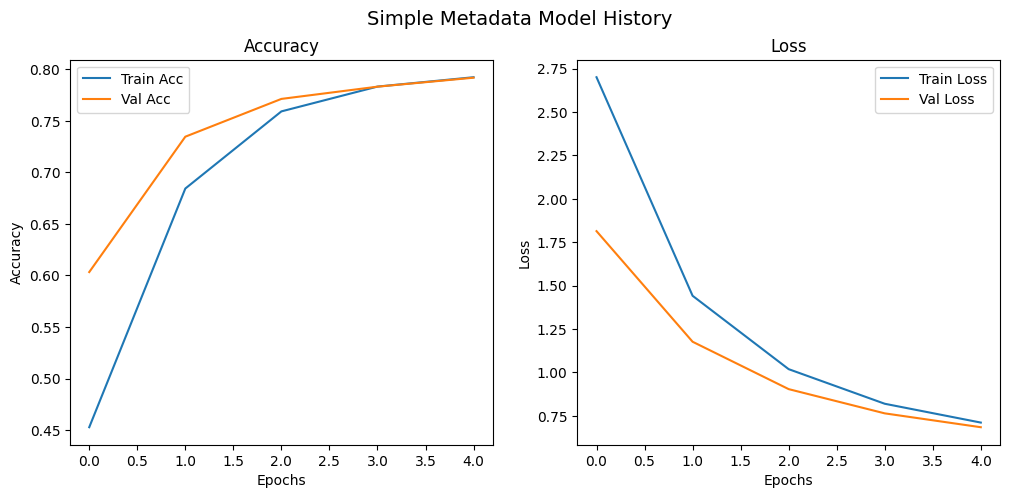

In [67]:
# Visualize history
plot_history(history_simple_metadata_model, "Simple Metadata Model History")

This small model is learning well but still underfits — training accuracy only reaches ~79%, with validation close behind at ~79% too. The gap is small, which means the model hasn’t yet reached its full capacity to capture patterns in the data. Next, we’ll deliberately push a larger model to overfit, so we can test how well it generalizes beyond the training set.

**OVERFITTED METADATA MODEL**

In [68]:
# Define build function for overfitted model
def build_overfit_model(input_dim, num_classes):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(1024, activation="relu")(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="overfit_model")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [69]:
# Build metadata overfit model
overfit_metadata_model = build_overfit_model(99, num_classes)
overfit_metadata_model.summary()

Model: "overfit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 99)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772,406 (2.95 MB)

 Trainable params: 772,406 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Fit metadata overfit model
history_metadata_overfit_model = overfit_metadata_model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=40,
    batch_size=128,
    verbose=1
)

Epoch 1/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6430 - loss: 1.3377 - val_accuracy: 0.7841 - val_loss: 0.5644
Epoch 2/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7961 - loss: 0.5315 - val_accuracy: 0.7773 - val_loss: 0.5475
Epoch 3/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7970 - loss: 0.5210 - val_accuracy: 0.7931 - val_loss: 0.5207
Epoch 4/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8012 - loss: 0.5023 - val_accuracy: 0.7884 - val_loss: 0.5297
Epoch 5/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.4930 - val_accuracy: 0.8005 - val_loss: 0.5266
Epoch 6/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8054 - loss: 0.4884 - val_accuracy: 0.7897 - val_loss: 0.5275
Epoch 7/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.4813 - val_accuracy: 0.7891 - val_loss: 0.5249
Epoch 8/40
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8131 - loss: 0.4622 - val_accuracy: 0

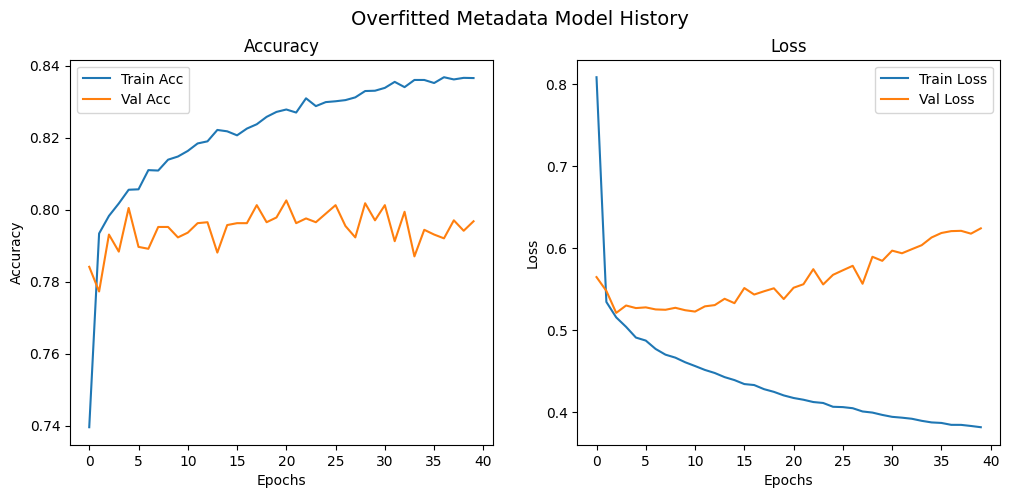

In [71]:
# Visualize history
plot_history(history_metadata_overfit_model, "Overfitted Metadata Model History")

The current model is not overfitting because its training accuracy is low, hovering around 83–84%.  
An overfit model would nearly memorize the training set, reaching 95–100% training accuracy. Since we don’t see this, the model is clearly limited in capacity rather than overfitting.  

Another sign is the very small gap between training and validation accuracy (about 84% vs 79%).  
When a model truly overfits, the training score keeps climbing while the validation score lags far behind, often with a gap of 20% or more. Here, both remain close, which shows the model isn’t memorizing.  

Validation accuracy is also holding steady instead of collapsing. In severe overfitting, validation accuracy usually stagnates or even declines as training accuracy continues to rise.

To actually demonstrate overfitting, we’ll reduce the size of the training data and force the model to memorize.  
By training on a much smaller subset (around 2,000 samples), the model should easily drive training accuracy much higher and expose the classic symptoms of overfitting.

**FORCE OVERFITTING**

In [72]:
# Use only a subset of training data to force memorization
X_small = X_train_processed[:2000]
y_small = y_train[:2000]

# Build model
subset_metadata_overfit_model = build_overfit_model(99, num_classes)

In [73]:
# Train the model
history_subset_metadata_overfit_model = subset_metadata_overfit_model.fit(
    X_small, y_small,
    validation_data=(X_val_processed, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3842 - loss: 2.7149 - val_accuracy: 0.7185 - val_loss: 1.0331
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7019 - loss: 0.9279 - val_accuracy: 0.7559 - val_loss: 0.7587
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7723 - loss: 0.6428 - val_accuracy: 0.7588 - val_loss: 0.6973
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7953 - loss: 0.5438 - val_accuracy: 0.7686 - val_loss: 0.6591
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8107 - loss: 0.4923 - val_accuracy: 0.7702 - val_loss: 0.6737
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8022 - loss: 0.4843 - val_accuracy: 0.7612 - val_loss: 0.7132
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8090 - loss: 0.4997 - val_accuracy: 0.7441 - val_loss: 0.6892
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8133 - loss: 0.4441 - val_accuracy: 0.7572 - val_l

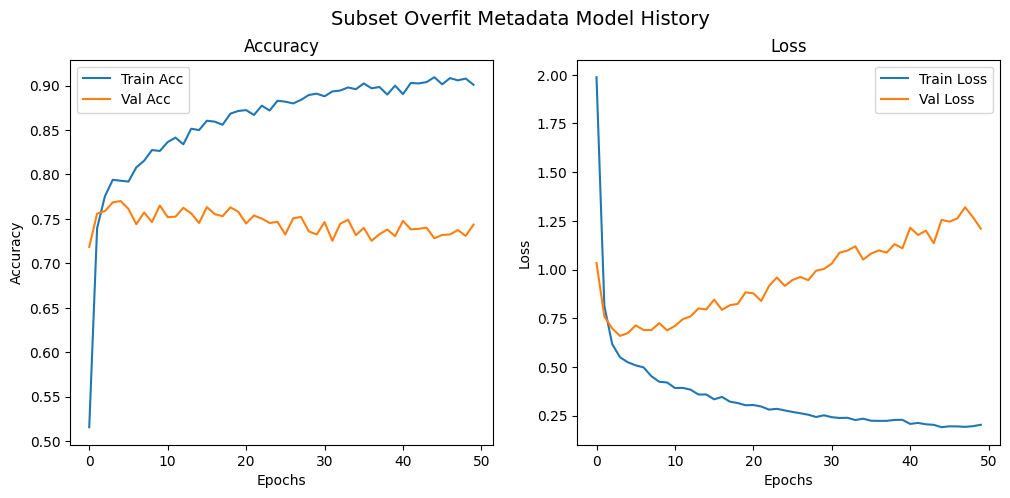

In [74]:
# Visualize history
plot_history(history_subset_metadata_overfit_model, "Subset Overfit Metadata Model History")

**REGULARIZED METADATA MODEL**

With the regularized model, we aim for a balanced fit that avoids both underfitting and overfitting.
We add L2 weight regularization, batch normalization, and dropout layers to control complexity and improve generalization.
This design allows the model to learn richer patterns from the metadata while keeping validation performance stable and closer to real-world conditions.

In [75]:
# Import regularizers
from tensorflow.keras import regularizers

# Function for regularized model
def build_regularized_model(input_dim, num_classes):
    inputs = keras.Input(shape=(input_dim,))

    x = layers.Dense(1024, use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(512, use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="regularized_model")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [76]:
# Build regularized metadata model
regularized_metadata_model = build_regularized_model(99, num_classes)
regularized_metadata_model.summary()

Model: "regularized_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 99)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       101,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,782 (2.97 MB)

 Trainable params: 774,198 (2.95 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [77]:
# Add callback
from tensorflow.keras.callbacks import ModelCheckpoint

regularized_metadata_callback = [
    ModelCheckpoint("saved_models/regularized_metadata_model.keras",
                    save_best_only=True,
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1)
]

In [78]:
# Fit regularized metadata model
history_regularized_metadata_model = regularized_metadata_model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=50,
    batch_size=128,
    verbose=1,
    callbacks=regularized_metadata_callback
)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6545 - loss: 1.3951
Epoch 1: val_accuracy improved from -inf to 0.77596, saving model to saved_models/regularized_metadata_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6548 - loss: 1.3935 - val_accuracy: 0.7760 - val_loss: 1.0923
Epoch 2/50
261/267 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7898 - loss: 0.6796
Epoch 2: val_accuracy improved from 0.77596 to 0.78940, saving model to saved_models/regularized_metadata_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7897 - loss: 0.6797 - val_accuracy: 0.7894 - val_loss: 0.6462
Epoch 3/50
252/267 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7921 - loss: 0.6592
Epoch 3: val_accuracy improved from 0.78940 to 0.79283, saving model to saved_models/regularized_metadata_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7921 - loss: 0.6590 - val_accuracy: 0.7928 - val_loss: 0.6378
Epoch 4/50
254/267 ━━━━━━━━━━━━━━━━━━

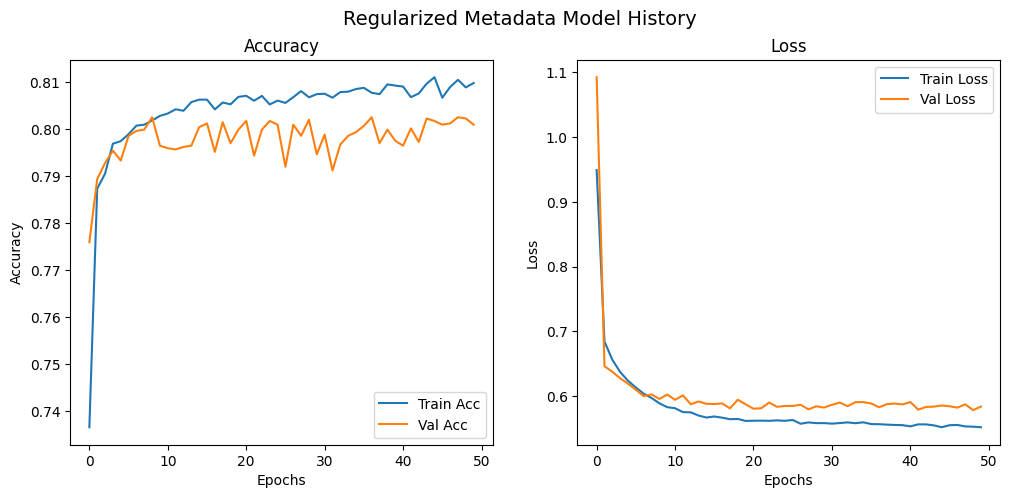

In [79]:
# Visualize history
plot_history(history_regularized_metadata_model, "Regularized Metadata Model History")

**EVALUATE REGULARIZED METADATA MODEL**

In this section, we’ll properly evaluate a regularized metadata model on the test set. Beyond just accuracy, we’ll check detailed metrics like precision, recall, and F1-score to see how well the model balances across different product categories. This helps us understand whether the model is consistently good across all classes, or if it’s leaning too heavily on the majority ones.

In [80]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Load best saved model
best_metadata_model = keras.models.load_model("saved_models/regularized_metadata_model.keras")
print("\nBest metadata model loaded from checkpoint")


Best metadata model loaded from checkpoint


In [81]:
# Evaluate metadata model on test set
test_loss, test_acc = best_metadata_model.evaluate(X_test_processed,
                                                   y_test, verbose=1)
print(f"Metadata-only model - Test Accuracy: {test_acc:.4f}, Test_Loss: {test_loss:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8101 - loss: 0.5697
Metadata-only model - Test Accuracy: 0.8081, Test_Loss: 0.5712


The metadata-only model hits about 81% accuracy on the test set. That’s actually pretty solid considering we only used product details like category, color, season, and gender. Still, it also shows the limits of this approach. Metadata alone can’t capture the finer product differences that are obvious in the images. That’s why will look at image-based models and see how much more we can squeeze out of the data before we bring everything together.

**PREDICTION**

In [82]:
# Make prediction with model
y_pred_probs = best_metadata_model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [83]:
# Classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report")
print(report)


Classification Report
                       precision    recall  f1-score   support

            Backpacks       0.93      0.96      0.95        72
                Belts       1.00      1.00      1.00        81
                  Bra       0.78      0.79      0.78        48
               Briefs       0.62      0.78      0.69        85
               Capris       0.33      0.18      0.23        17
                 Caps       1.00      1.00      1.00        28
         Casual Shoes       0.94      0.95      0.95       284
             Clutches       0.50      0.10      0.17        29
            Cufflinks       1.00      1.00      1.00        11
            Deodorant       0.00      0.00      0.00        35
              Dresses       1.00      1.00      1.00        46
              Dupatta       0.67      0.17      0.27        12
             Earrings       0.63      1.00      0.77        42
                Flats       0.86      0.12      0.21        50
           Flip Flops       1.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
# Macro/Weighted F1-scores
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")

# Print results
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

Macro F1-Score: 0.6555
Weighted F1-Score: 0.7778


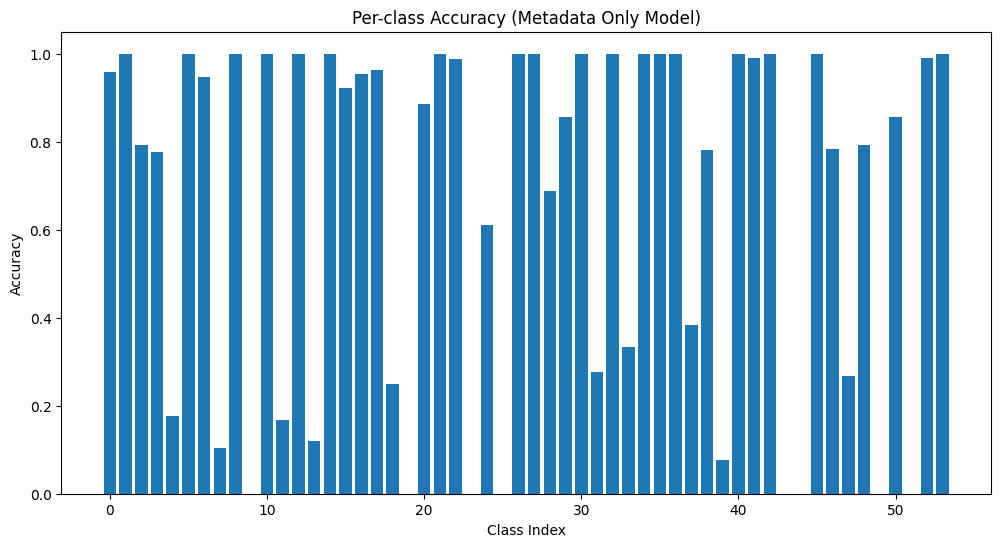

In [85]:
# List to store per-class accuracy
class_acc = []

for c in np.unique(y_test):
    class_mask = (y_test == c)
    acc = (y_pred[class_mask] == y_test[class_mask]).mean()
    class_acc.append(acc)

# Plot bar chart of per-class accuracy
plt.figure(figsize=(12,6))
plt.bar(range(len(class_acc)), class_acc)
plt.title("Per-class Accuracy (Metadata Only Model)")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")

# Save figure
plt.savefig("per_class_accuracy.png", bbox_inches="tight")

plt.show()


We dug deeper into the model’s performance by looking at accuracy per class, not just overall accuracy.

Instead of asking “how often is the model right in general?”, we ask “how often is it right for each specific category?”.

This is important because some classes may have many samples (easy to learn) while others have fewer (harder to learn).

Through the plot, we can see where the model struggles and where it performs well.

**IMAGE MODELLING**

Now we shift focus from metadata to images. The goal here is to see how much predictive power lies in the visual patterns of the products themselves. By training models directly on the images, we can capture details like shape, texture, and style that metadata alone can’t describe. This will give us a clearer picture of how image-based features compare against metadata features before we eventually combine both.


**DATA PREPARATION**

In [86]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [87]:
# Set out constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [88]:
# Display few rows in styles data
display(styles.head())

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/e-comrec-dataset/archive (8)/myn...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/e-comrec-dataset/archive (8)/myn...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/e-comrec-dataset/archive (8)/myn...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...


In [89]:
# Length of our split samples
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total_samples: {len(train_df) + len(val_df) + len(test_df)}")

Train samples: 34141
Validation samples: 3794
Test samples: 4215
Total_samples: 42150


In [90]:
# Display few rows of train data
display(train_df.head())

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
41130,2493,Men,Apparel,Topwear,Tshirts,White,Fall,2010.0,Casual,Puma Men's White Polo T-shirt,/kaggle/input/e-comrec-dataset/archive (8)/myn...
32058,37312,Men,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Casio Edifice Men Multi-Dial Watch EF-334D-7AV...,/kaggle/input/e-comrec-dataset/archive (8)/myn...
25945,3969,Women,Apparel,Topwear,Tops,Black,Summer,2011.0,Casual,Jealous 21 Women Black V Neck With Sequins Top,/kaggle/input/e-comrec-dataset/archive (8)/myn...
39058,55623,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Numero Uno Men Black Shoes,/kaggle/input/e-comrec-dataset/archive (8)/myn...
22634,37227,Men,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,United Colors of Benetton Men Black Backpack,/kaggle/input/e-comrec-dataset/archive (8)/myn...


**DIRECTORY STRUCTURE**

Before training an image model, we need to organize the dataset in a way that Keras and other deep learning libraries can easily work with. We will create a clean directory structure where images are sorted into folders by their class (articleType) for each split (train, validation, test).

In [91]:
# Create directory structure for image datasets

import shutil

def create_image_dataset_structure(df, split_name, base_dir='/tmp/ecom_images'):
    """Directory structure for image dataset split"""
    split_dir = os.path.join(base_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    # Create category directories
    for category in df['articleType'].unique():
        category_dir = os.path.join(split_dir, category)
        os.makedirs(category_dir, exist_ok=True)

    # Copy images to appropriate directories
    for _, row in df.iterrows():
        src_path = row['image_path']
        category = row['articleType']
        dest_path = os.path.join(split_dir, category, os.path.basename(src_path))

        if not os.path.exists(dest_path):
            shutil.copy2(src_path, dest_path)

    return split_dir

In [92]:
# Create the dataset structure
base_dir = '/tmp/eocom_images'
train_dir = create_image_dataset_structure(train_df, "train", base_dir)
val_dir = create_image_dataset_structure(val_df, "validation", base_dir)
test_dir = create_image_dataset_structure(test_df, "test", base_dir)

print(f"\nDataset directories created:")
print(f"\nTrain: {train_df}")
print(f"\nValidation: {val_dir}")
print(f"\nTest: {test_dir}")


Dataset directories created:

Train:           id  gender masterCategory subCategory   articleType baseColour  \
41130   2493     Men        Apparel     Topwear       Tshirts      White   
32058  37312     Men    Accessories     Watches       Watches     Silver   
25945   3969   Women        Apparel     Topwear          Tops      Black   
39058  55623     Men       Footwear       Shoes  Casual Shoes      Black   
22634  37227     Men    Accessories        Bags     Backpacks      Black   
...      ...     ...            ...         ...           ...        ...   
163    21510   Women    Accessories        Bags      Handbags      White   
1385   18864     Men        Apparel     Topwear   Sweatshirts      Black   
15098   9908  Unisex    Accessories        Bags      Handbags      Green   
38498   5023     Men        Apparel     Topwear        Shirts        Red   
9352   11497   Women       Footwear       Shoes         Heels       Pink   

       season    year   usage  \
41130    Fall  2

In [93]:
# Create datasets using image_dataset_from_directory
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("\nCreate datasets")

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=123
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)


Create datasets
Found 34141 files belonging to 54 classes.
Found 3794 files belonging to 54 classes.
Found 4215 files belonging to 54 classes.


In [94]:
# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_ds.file_paths)}")
print(f"Validation samples: {len(val_ds.file_paths)}")
print(f"Test samples: {len(test_ds.file_paths)}")

Number of classes: 54
Training samples: 34141
Validation samples: 3794
Test samples: 4215


To speed up training, we optimize the dataset pipeline using `cache()` and `prefetch()`.  

Caching keeps the data in memory after the first load, avoiding repeated disk reads.  

Prefetching overlaps data loading with model training so the GPU/CPU never sits idle.

With `AUTOTUNE`, TensorFlow automatically picks the best prefetch buffer size.  


In [95]:
# Optimize dataset performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
# Check a batch of data
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Pixel value range: [{tf.reduce_min(images):.1f}, {tf.reduce_max(images):.1f}]")
    break

Image batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 54)
Image data type: <dtype: 'float32'>
Pixel value range: [0.0, 255.0]


In [97]:
# Save split information for later fusion with metadata
split_info = {
    "train_ids": train_df["id"].tolist(),
    "val_ids": val_df["id"].tolist(),
    "test_ids": test_df["id"].tolist(),
    "class_names": class_names
}

import json
with open("image_split_info.json", "w") as f:
    json.dump(split_info, f)

print("Split information saved to 'image_split_info.json'")

Split information saved to 'image_split_info.json'


In [98]:
# Shape of image
print(f"Number of classes: {num_classes}")
print(f"Input shape: {IMG_SIZE + (3,)}")

Number of classes: 54
Input shape: (128, 128, 3)


**SMALL MODEL**

In [99]:
# small cnn baseline model
def build_baseline_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(8, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn")
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [100]:
# Build baseline cnn model
baseline_cnn_model = build_baseline_cnn(IMG_SIZE + (3,), num_classes)
baseline_cnn_model.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │       508,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 54)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 509,190 (1.94 MB)

 Trainable params: 509,190 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Fit model
history_baseline_cnn_model = baseline_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.1648 - loss: 3.9165 - val_accuracy: 0.1676 - val_loss: 3.5696
Epoch 2/5
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1702 - loss: 3.5195 - val_accuracy: 0.1676 - val_loss: 3.4268
Epoch 3/5
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1702 - loss: 3.4120 - val_accuracy: 0.1676 - val_loss: 3.3931
Epoch 4/5
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1702 - loss: 3.3880 - val_accuracy: 0.1676 - val_loss: 3.3866
Epoch 5/5
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1702 - loss: 3.3832 - val_accuracy: 0.1676 - val_loss: 3.3849


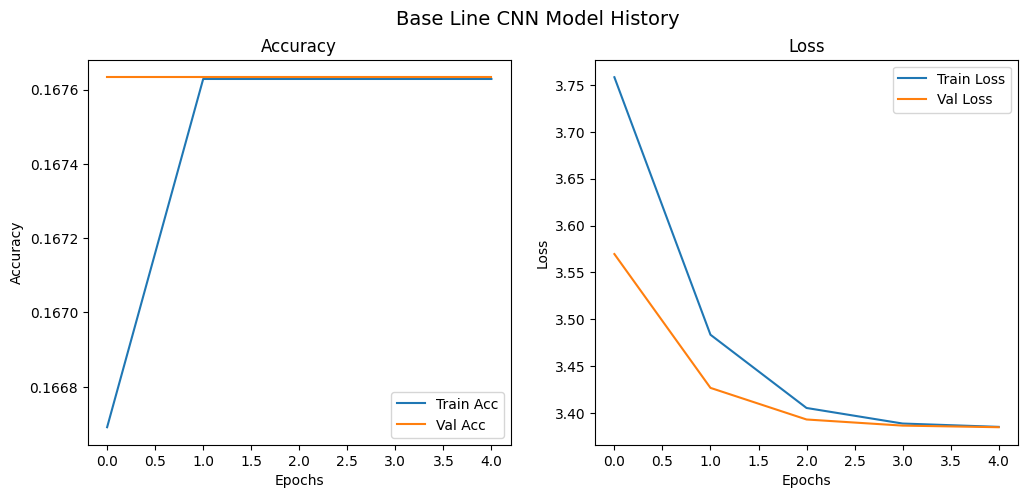

In [102]:
# Visualize history
plot_history(history_baseline_cnn_model, "Base Line CNN Model History")

This small CNN is clearly underfitting. Both training and validation accuracy are stuck around 16–17%, which is barely better than random guessing across many classes. The loss also plateaus quickly without showing real learning progress. This tells us that the model is too simple and lacks the capacity to capture useful patterns from the images. In the next steps, we’ll move to a higher-capacity model to check if it can actually memorize the data, before applying regularization for a proper fit.

**OVERFIT CNN MODEL**

Here we deliberately trained on only 5 batches of the training set to force the model to memorize. By using a small subset of the data, even a relatively simple CNN can quickly overfit and achieve near-perfect accuracy on the training portion. This experiment is important because it proves that the model architecture has enough capacity to learn patterns from the data. The downside, of course, is that validation accuracy won’t improve much — it shows the model isn’t generalizing, only memorizing. This is exactly what we expect at this stage before moving on to a regularized, properly trained model.

In [103]:
# 5 batches
small_train_ds = train_ds.take(5)

In [104]:
# Build overfit model
def build_overfit_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="overfit_cnn")
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [105]:
# Build overfit CNN model
overfit_cnn_model = build_overfit_cnn(IMG_SIZE + (3,), num_classes)
overfit_cnn_model.summary()

Model: "overfit_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,535,862 (120.30 MB)

 Trainable params: 31,535,862 (120.30 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Fit CNN overfit model
history_overfit_cnn_model = overfit_cnn_model.fit(
    small_train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0812 - loss: 16.6682 - val_accuracy: 0.0066 - val_loss: 4.0918
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step - accuracy: 0.0391 - loss: 3.9903 - val_accuracy: 0.1676 - val_loss: 3.6837
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.2055 - loss: 3.5427 - val_accuracy: 0.1671 - val_loss: 3.3959
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.2371 - loss: 2.9136 - val_accuracy: 0.2615 - val_loss: 3.0904
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.5032 - loss: 2.1991 - val_accuracy: 0.3065 - val_loss: 3.0746
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.6208 - loss: 1.6243 - val_accuracy: 0.3701 - val_loss: 3.0143
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.7559 - loss: 1.0370 - val_accuracy: 0.4175 - val_loss: 2.8272
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.8819 - loss: 0.6063 - val_accuracy: 0.4526 - val_loss: 

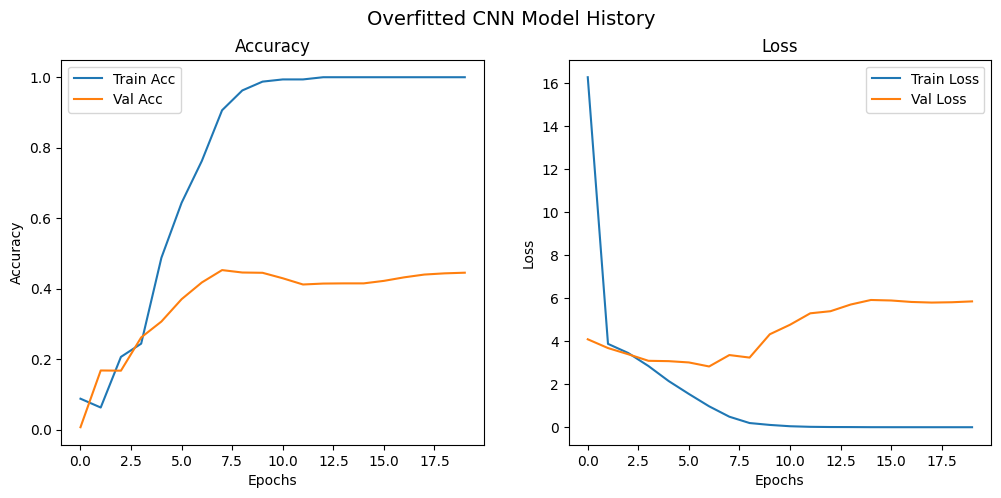

In [107]:
# Visualize history
plot_history(history_overfit_cnn_model, "Overfitted CNN Model History")

As expected, the overfit CNN quickly memorized the small training subset. Training accuracy shoots up to 100%, and the loss drops near zero, showing the model can perfectly “remember” these examples.

However, validation accuracy barely improves and the loss remains high, which clearly shows the model fails to generalize beyond the small training set.

This confirms the network has enough capacity to learn patterns but also highlights the need for proper regularization when training on the full dataset.

**REGULARIZED CNN MODEL**

In this section, we move to a regularized image model using a pre-trained EfficientNetB0 backbone. We freeze the base model to leverage pre-learned visual features and apply data augmentation to improve generalization. We added Dropout to prevent overfitting. This setup allows the network to learn robust image representations without memorizing the training set, providing a strong foundation before we combine images with metadata in the fusion model.

In [108]:
# Import EfficientNetB0 pretrained model
from tensorflow.keras.applications import EfficientNetB0

# Define build function forregularized cnn model
def build_regularized_image_model(input_shape, num_classes):
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="efficientnetb0_regularized")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [109]:
# Build regularized cnn model
regularized_cnn_model = build_regularized_image_model(IMG_SIZE + (3,), num_classes)
regularized_cnn_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0_regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 54)             │        69,174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,118,745 (15.71 MB)

 Trainable params: 69,174 (270.21 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [110]:
# Add callbacks
regularized_cnn_callbacks = [
    keras.callbacks.ModelCheckpoint(
        "saved_models/regularized_image_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor="val_accuracy"
    )]

In [111]:
# Fit regularized cnn model
history_regularized_cnn_model = regularized_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=regularized_cnn_callbacks,
    verbose=1
)

Epoch 1/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.6216 - loss: 1.3990 - val_accuracy: 0.8102 - val_loss: 0.5774
Epoch 2/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.7966 - loss: 0.6274 - val_accuracy: 0.8218 - val_loss: 0.5197
Epoch 3/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.8118 - loss: 0.5651 - val_accuracy: 0.8363 - val_loss: 0.4976
Epoch 4/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.8195 - loss: 0.5279 - val_accuracy: 0.8374 - val_loss: 0.4772
Epoch 5/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.8253 - loss: 0.5105 - val_accuracy: 0.8355 - val_loss: 0.4760
Epoch 6/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.8308 - loss: 0.4994 - val_accuracy: 0.8387 - val_loss: 0.4669
Epoch 7/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.8320 - loss: 0.4865 - val_accuracy: 0.8397 - val_loss: 0.4653
Epoch 8/20
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.8325 -

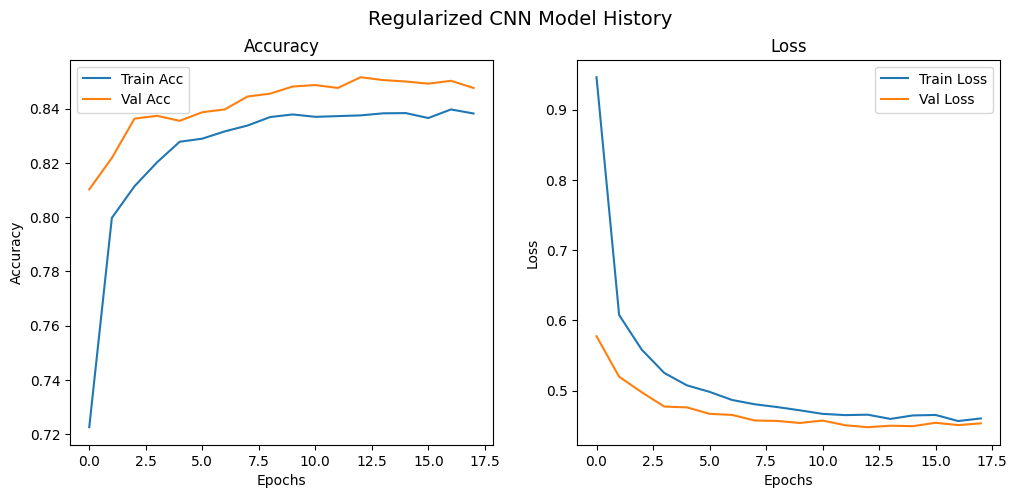

In [112]:
# Visualize history
plot_history(history_regularized_cnn_model, "Regularized CNN Model History")

The regularized CNN model is learning well and generalizing much better than the overfit model. Training accuracy steadily improves, and validation accuracy remains close behind, hovering around 84–85%. The loss decreases gradually without any drastic divergence, indicating that the model is fitting properly without memorizing the data. This shows that the combination of data augmentation, dropout, and a frozen EfficientNetB0 backbone is helping the network learn meaningful patterns from the images while avoiding overfitting.

**EVALUATE IMAGE MODEL**

In [113]:
# Load best saved models
best_image_model = keras.models.load_model("saved_models/regularized_image_model.keras")

# Evaluate on test set
test_loss, test_accuracy = best_image_model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8540 - loss: 0.4218
Test Accuracy: 0.8577
Test Loss: 0.4181


The regularized image model performs well on the test set, achieving about 86% accuracy. This confirms that the model has learned meaningful visual features and generalizes effectively to unseen images, while keeping the loss reasonably low. It sets a strong baseline before we move on to combining image and metadata features in the fusion model.

In [114]:
# Compute F1-Score
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_image_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Classification Report
                       precision    recall  f1-score   support

            Backpacks     0.9714    0.9444    0.9577        72
                Belts     0.9878    1.0000    0.9939        81
                  Bra     0.9592    0.9792    0.9691        48
               Briefs     0.9767    0.9882    0.9825        85
               Capris     0.6667    0.3529    0.4615        17
                 Caps     1.0000    0.9643    0.9818        28
         Casual Shoes     0.7740    0.7958    0.7847       284
             Clutches     0.7143    0.5172    0.6000        29
            Cufflinks     1.0000    0.7273    0.8421        11
            Deodorant     0.8718    0.9714    0.9189        35
              Dresses     0.6531    0.6957    0.6737        46
              Dupatta     1.0000    0.7500    0.8571        12
             Earrings     0.9318    0.9762    0.9535        42
                Flats     0.4706    0.1600    0.2388        50
           Flip Flops     0.784

The image-only model delivers a solid overall accuracy of about 86%, which is strong given the large number of product categories. High-performing classes like Belts, Watches, Lipstick, Socks, and Sunglasses reach near-perfect scores, showing the model can recognize many items very reliably.

However, performance drops for categories with fewer or more visually similar examples, such as Capris, Flats, Kurtis, Tunics, and Sweaters, where recall and f1-scores are much lower. This highlights the limits of relying on images alone, especially when classes overlap visually or don’t have enough training samples.

The macro f1-score of 0.81 shows that while some categories shine, others are much weaker, but the weighted average of 0.85 confirms the model handles the dataset well overall. Strengthening underrepresented classes with more data or combining images with other features could help close the gap further.

## **FUSION MODEL**

In this section, we put together metadata and images into one model. The idea is to use both the product details and pictures so the model can make better guesses about the product category than using just one type of data.

In [115]:
# Convert metadata to dense arrays (if sparse)
X_train_dense = X_train_processed.toarray().astype(np.float32)
X_val_dense   = X_val_processed.toarray().astype(np.float32)
X_test_dense  = X_test_processed.toarray().astype(np.float32)

In [116]:
# Inspect train
for images, labels in train_ds.take(1):
    print("images shape:", images.shape)
    print("labels shape:", labels.shape)

images shape: (32, 128, 128, 3)
labels shape: (32, 54)


In [117]:
# Create tf.data datasets for metadata
train_meta_ds = tf.data.Dataset.from_tensor_slices(X_train_dense)
val_meta_ds   = tf.data.Dataset.from_tensor_slices(X_val_dense)
test_meta_ds  = tf.data.Dataset.from_tensor_slices(X_test_dense)

In [118]:
# Function to combine image_ds with labels and meta_ds
def create_fusion_dataset(image_ds, meta_ds, batch_size):
    image_ds = image_ds.unbatch()
    meta_ds  = meta_ds
    fusion_ds = tf.data.Dataset.zip((image_ds, meta_ds))

    def map_fn(image_label, meta):
        image, label = image_label
        return {"image_input": image, "meta_input": meta}, label

    fusion_ds = fusion_ds.map(map_fn)
    fusion_ds = fusion_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return fusion_ds

In [119]:
# Create fusion datasets
train_fusion_ds = create_fusion_dataset(train_ds, train_meta_ds, BATCH_SIZE)
val_fusion_ds   = create_fusion_dataset(val_ds, val_meta_ds, BATCH_SIZE)
test_fusion_ds  = create_fusion_dataset(test_ds, test_meta_ds, BATCH_SIZE)

In [120]:
# Define function to build fusion model
def build_fusion_model(image_shape, meta_dim, num_classes):
    # Image branch
    data_aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    base_model = EfficientNetB0(
        input_shape=image_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    image_inputs = keras.Input(shape=image_shape, name="image_input")
    x_img = data_aug(image_inputs)
    x_img = base_model(x_img, training=False)
    x_img = layers.GlobalAveragePooling2D()(x_img)
    x_img = layers.Dropout(0.4)(x_img)
    x_img = layers.Dense(256, activation="relu")(x_img)

    # Metadata branch
    meta_inputs = keras.Input(shape=(meta_dim,), name="meta_input")
    x_meta = layers.Dense(1024, use_bias=False,
                          kernel_regularizer=regularizers.l2(1e-4))(meta_inputs)
    x_meta = layers.BatchNormalization()(x_meta)
    x_meta = layers.Activation("relu")(x_meta)
    x_meta = layers.Dropout(0.4)(x_meta)

    x_meta = layers.Dense(512, use_bias=False,
                          kernel_regularizer=regularizers.l2(1e-4))(x_meta)
    x_meta = layers.BatchNormalization()(x_meta)
    x_meta = layers.Activation("relu")(x_meta)
    x_meta = layers.Dropout(0.3)(x_meta)

    x_meta = layers.Dense(256, use_bias=False,
                          kernel_regularizer=regularizers.l2(1e-4))(x_meta)
    x_meta = layers.BatchNormalization()(x_meta)
    x_meta = layers.Activation("relu")(x_meta)
    x_meta = layers.Dropout(0.2)(x_meta)

    # Fusion
    combined = layers.concatenate([x_img, x_meta])
    x = layers.Dense(256, activation="relu")(combined)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(
        inputs=[image_inputs, meta_inputs],
        outputs=outputs,
        name="fusion_model"
    )

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [121]:
# Build fusion model
fusion_model = build_fusion_model(
    image_shape=(128,128,3),
    meta_dim=X_train_dense.shape[1],
    num_classes=num_classes
)
fusion_model.summary()

Model: "fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meta_input          │ (None, 99)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1024)      │    101,376 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1024)      │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │    524,288 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ sequential_1[0][… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    131,072 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    327,936 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,286,617 (20.17 MB)

 Trainable params: 1,233,462 (4.71 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [122]:
# Add Callbacks
fusion_callbacks = [
    keras.callbacks.ModelCheckpoint(
        "saved_models/fusion_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        patience=5,
        monitor="val_accuracy",
        restore_best_weights=True
    )
]


In [123]:
# Train Fusion Model
history_fusion_model = fusion_model.fit(
    train_fusion_ds,
    validation_data=val_fusion_ds,
    epochs=30,
    callbacks=fusion_callbacks,
    verbose=1
)

Epoch 1/30
   1067/Unknown 53s 37ms/step - accuracy: 0.5809 - loss: 1.6570

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.79652, saving model to saved_models/fusion_model.keras
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accuracy: 0.5810 - loss: 1.6566 - val_accuracy: 0.7965 - val_loss: 0.7275
Epoch 2/30
1066/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7648 - loss: 0.8299
Epoch 2: val_accuracy improved from 0.79652 to 0.80917, saving model to saved_models/fusion_model.keras
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 77s 41ms/step - accuracy: 0.7648 - loss: 0.8299 - val_accuracy: 0.8092 - val_loss: 0.6429
Epoch 3/30
1066/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7849 - loss: 0.7229
Epoch 3: val_accuracy improved from 0.80917 to 0.82604, saving model to saved_models/fusion_model.keras
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.7849 - loss: 0.7229 - val_accuracy: 0.8260 - val_loss: 0.5672
Epoch 4/30
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7952 - loss: 0.6606
Epoch 4: val_accuracy improved from 0.82604 to 0.83079, savi

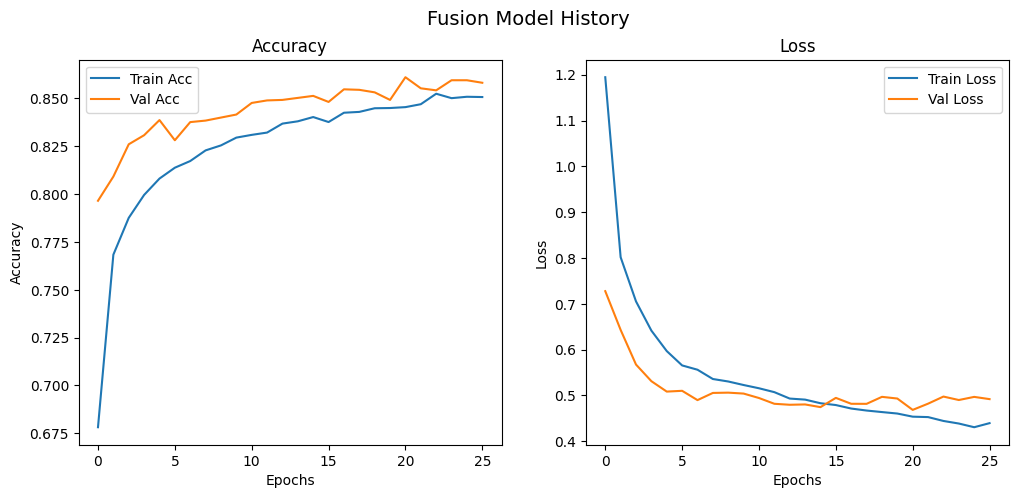

In [124]:
# Visualize history
plot_history(history_fusion_model, "Fusion Model History")

The fusion model showed strong learning from the start, moving from about 58% accuracy in the first epoch to over 80% within just a few rounds. Validation accuracy followed the same trend, peaking around 86% at epoch 21 before starting to level off. After that point, training accuracy kept improving while validation gains slowed, a clear sign of mild overfitting. The best checkpoint was saved at epoch 21, making it a good stopping point for future runs instead of training all 30 epochs.

**EVALUATE MODEL ON TEST SET**

In [125]:
# Load best saved model
best_fusion_model = keras.models.load_model("saved_models/fusion_model.keras")

# Evaluate fusion model
test_loss, test_acc = best_fusion_model.evaluate(test_fusion_ds, verbose=1)
print(f"Fusion Test Accuracy: {test_acc:.4f}")
print(f"Fusion Test Loss: {test_loss:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8553 - loss: 0.4494
Fusion Test Accuracy: 0.8636
Fusion Test Loss: 0.4294


On the held-out test set, the fusion model reached about 86% accuracy with a loss of 0.43. This is consistent with the best validation performance, which shows that the model is generalizing well and not just memorizing the training data. It confirms that the saved checkpoint was a solid choice for deployment or further analysis.

**PREDICTIONS**

In [126]:
# Predictions
y_pred_probs = fusion_model.predict(test_fusion_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_fusion_ds])

132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step


In [127]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

            Backpacks       0.93      0.96      0.95        72
                Belts       0.98      1.00      0.99        81
                  Bra       0.98      0.96      0.97        48
               Briefs       1.00      0.94      0.97        85
               Capris       0.89      0.47      0.62        17
                 Caps       1.00      0.89      0.94        28
         Casual Shoes       0.79      0.80      0.79       284
             Clutches       0.76      0.45      0.57        29
            Cufflinks       1.00      0.82      0.90        11
            Deodorant       0.89      0.97      0.93        35
              Dresses       0.73      0.72      0.73        46
              Dupatta       0.86      0.50      0.63        12
             Earrings       0.95      0.98      0.96        42
                Flats       0.29      0.08      0.12        50
           Flip Flops       0.83      0.82      0.83  

The classification report shows the fusion model performing strongly across most categories, with an overall accuracy of 86% on the test set. Many classes like Belts, Lipstick, Watches, Sunglasses, and Sarees reach near-perfect precision and recall, which means the model identifies them very reliably.

At the same time, some categories with fewer training examples (such as Capris, Tunics, Flats, and Clutches) have much lower recall and f1-scores, showing the challenge of imbalanced data. Despite this, the macro average f1-score of 0.81 and weighted average of 0.86 confirm that performance is consistent across most classes.

**CONCLUSION**

Looking at the results, the metadata-only model reached about 81% accuracy, which shows that product details carry useful signals but aren’t enough on their own. The image-only model did better at 85.7% accuracy, which makes sense since visuals are often the strongest clue in e-commerce. The fusion model, which combines both, came out on top at about 86.4% accuracy.

The gain may look small on paper, but at catalog scale it means thousands more products tagged correctly and fewer errors slipping through. For the business, that translates to smoother search results, smarter recommendations, and less manual rework for merchandising teams. Even a modest boost in accuracy makes the shopping experience more reliable and reduces the cost of mistakes.